# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [2]:
url_sensor = '/content/drive/MyDrive/TCC-Solo/Sensores/sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC-Solo/Sensores/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

url_qualidade_ar = '/content/drive/MyDrive/TCC-Solo/Sensores/ind_qual_ar_17_24.csv'

df_qualidade_ar = pd.read_csv(url_qualidade_ar, sep=',')

In [3]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5', 'lat', 'lon']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

/tmp/ipython-input-6-1024544581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%m/%d/%Y %I:%M:%S %p')
/tmp/ipython-input-6-1024544581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
/tmp/ipython-input-6-1024544581.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[df_sensor_interest['ano'] > 2011]

In [8]:
#@title Filtrando por Tijuca
df_sensor_tijuca = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO TIJUCA']

In [9]:
df_qualidade_ar['data_formatada'] = pd.to_datetime(df_qualidade_ar['data']).dt.strftime('%Y-%m-%d')
df_qualidade_ar_tijuca = df_qualidade_ar[df_qualidade_ar['estacao_nome'] == 'Tijuca']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação Tijuca
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva

In [10]:
df_sensor_tijuca['chuva'].describe()

,chuva
count,108144.000000
mean,0.156763
std,2.849229
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,297.400000


In [11]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 5835


In [12]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['chuva_nulos_no_dia'] = (
    df_sensor_tijuca['chuva'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-12-2960750183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['chuva_nulos_no_dia'] = (


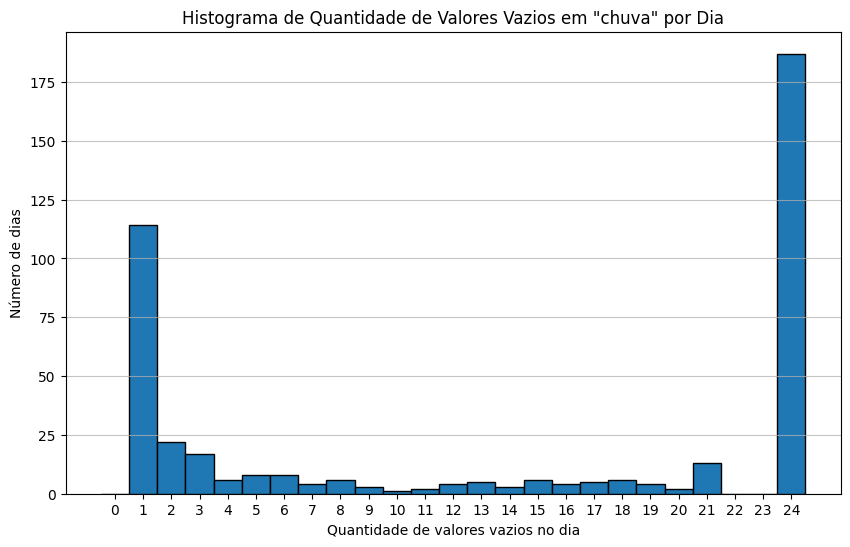

In [13]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [14]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_tijuca['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['chuva'].isnull().sum()
df_sensor_tijuca.loc[mask, 'chuva'] = df_sensor_tijuca[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

321 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 6% de dados


In [15]:
df_sensor_tijuca['chuva'].describe()

,chuva
count,108465.000000
mean,0.156946
std,2.845540
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,297.400000


### Temperatura

In [16]:
df_sensor_tijuca['temp'].describe()

,temp
count,106987.00000
mean,24.82156
std,5.72167
min,11.32000
25%,20.67000
50%,23.90000
75%,28.00000
max,49.16000


In [17]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 6992


In [18]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['temp_nulos_no_dia'] = (
    df_sensor_tijuca['temp'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-18-146835093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['temp_nulos_no_dia'] = (


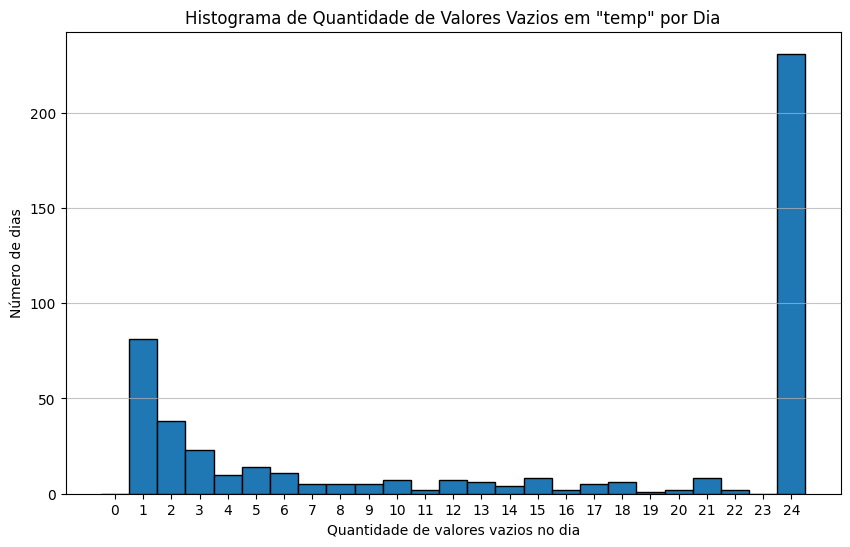

In [19]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [20]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['temp'].isnull().sum()
df_sensor_tijuca.loc[mask, 'temp'] = df_sensor_tijuca[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

402 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 6% de dados


In [21]:
df_sensor_tijuca['temp'].describe()

,temp
count,107389.000000
mean,24.827435
std,5.720164
min,11.320000
25%,20.680000
50%,23.920000
75%,28.020000
max,49.160000


### Umidade relativa

In [22]:
df_sensor_tijuca['ur'].describe()

,ur
count,106841.000000
mean,65.014546
std,19.087443
min,10.330000
25%,51.670000
50%,66.900000
75%,79.180000
max,99.910000


In [23]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7138


In [24]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['ur_nulos_no_dia'] = (
    df_sensor_tijuca['ur'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-24-4203217833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['ur_nulos_no_dia'] = (


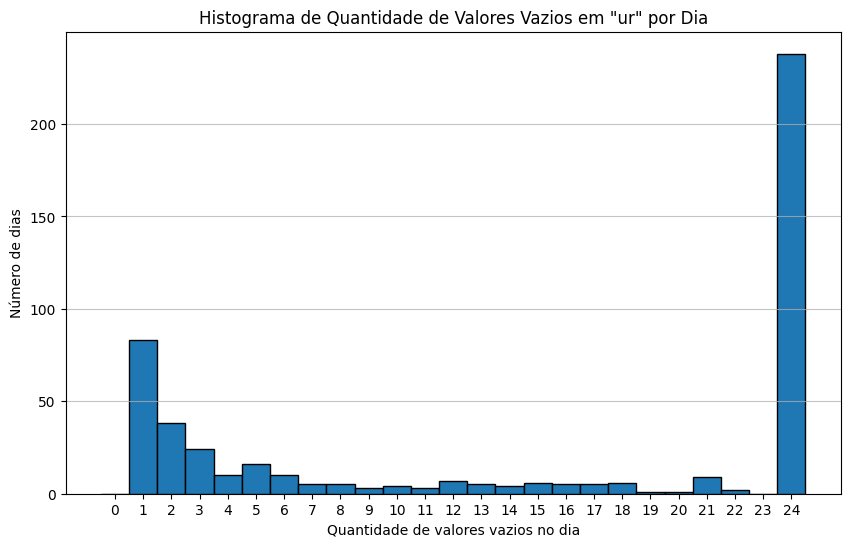

In [25]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [26]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['ur'].isnull().sum()
df_sensor_tijuca.loc[mask, 'ur'] = df_sensor_tijuca[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

411 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 6% de dados


In [27]:
df_sensor_tijuca['ur'].describe()

,ur
count,107252.000000
mean,65.011748
std,19.083123
min,10.330000
25%,51.670000
50%,66.880000
75%,79.170000
max,99.910000


### Monóxido de carbono

In [28]:
df_sensor_tijuca['co'].describe()

,co
count,82989.000000
mean,0.424171
std,0.257947
min,0.000000
25%,0.260000
50%,0.390000
75%,0.540000
max,12.080000


In [29]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 30990


In [30]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['co_nulos_no_dia'] = (
    df_sensor_tijuca['co'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-30-2097982054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['co_nulos_no_dia'] = (


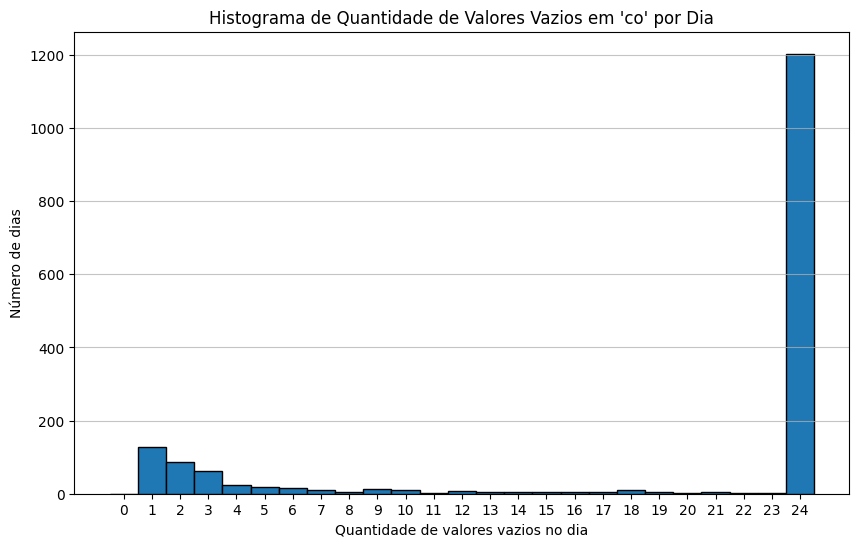

In [31]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [32]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['co'].isnull().sum()
df_sensor_tijuca.loc[mask, 'co'] = df_sensor_tijuca[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

777 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 3% de dados


In [33]:
df_sensor_tijuca['co'].describe()

,co
count,83766.000000
mean,0.424752
std,0.258554
min,0.000000
25%,0.266875
50%,0.390000
75%,0.540000
max,12.080000


### Monóxido de Nitrogênio

In [34]:
df_sensor_tijuca['no'].describe()

,no
count,78039.000000
mean,13.774888
std,15.614423
min,0.000000
25%,4.280000
50%,9.070000
75%,17.480000
max,253.920000


In [35]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['no'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 35940


In [36]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['no_nulos_no_dia'] = (
    df_sensor_tijuca['no'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-36-2119564368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['no_nulos_no_dia'] = (


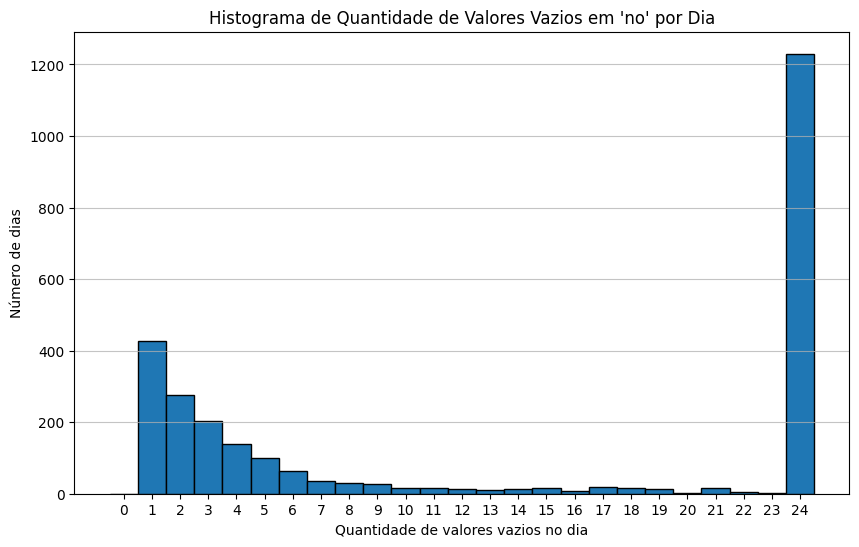

In [37]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['no_nulos_no_dia'] != 0].groupby('data_formatada')['no_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [38]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['no_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['no'].isnull().sum()
df_sensor_tijuca.loc[mask, 'no'] = df_sensor_tijuca[mask]['no'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

3019 linhas foram preenchidas com interpolate na coluna 'no'.
Foram preenchido 8% de dados


In [39]:
df_sensor_tijuca['no'].describe()

,no
count,81058.000000
mean,13.511477
std,15.508762
min,0.000000
25%,4.080000
50%,8.800000
75%,17.160000
max,253.920000


### Dióxido de Nitrogênio

In [40]:
df_sensor_tijuca['no2'].describe()

,no2
count,78174.000000
mean,39.599962
std,23.607305
min,0.000000
25%,22.050000
50%,35.580000
75%,52.340000
max,235.930000


In [41]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['no2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 35805


In [42]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['no2_nulos_no_dia'] = (
    df_sensor_tijuca['no2'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-42-718876325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['no2_nulos_no_dia'] = (


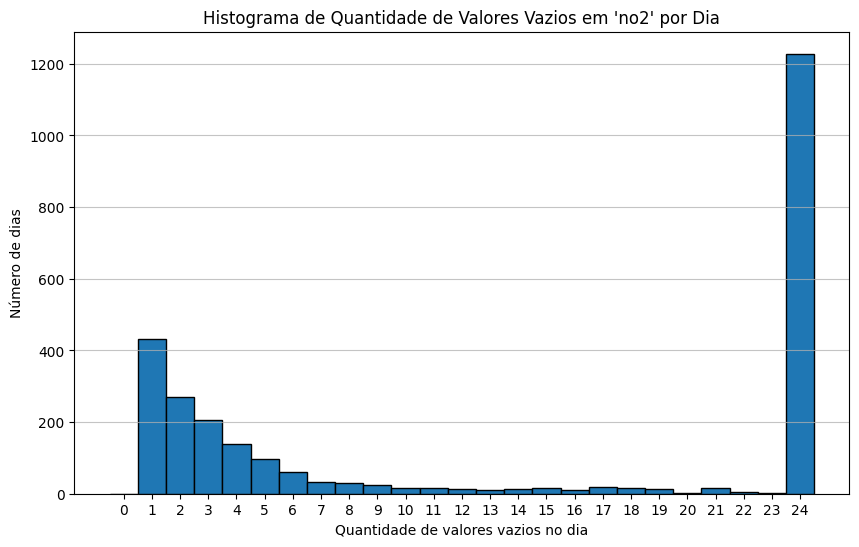

In [43]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['no2_nulos_no_dia'] != 0].groupby('data_formatada')['no2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [44]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['no2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['no2'].isnull().sum()
df_sensor_tijuca.loc[mask, 'no2'] = df_sensor_tijuca[mask]['no2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2996 linhas foram preenchidas com interpolate na coluna 'no2'.
Foram preenchido 8% de dados


In [45]:
df_sensor_tijuca['no2'].describe()

,no2
count,81170.000000
mean,39.200349
std,23.548556
min,0.000000
25%,21.730000
50%,35.150000
75%,51.880000
max,235.930000


### Óxido de Nitrogênio

In [46]:
df_sensor_tijuca['nox'].describe()

,nox
count,78195.00000
mean,53.20507
std,34.01654
min,0.00000
25%,29.21000
50%,46.28000
75%,69.13000
max,418.47000


In [47]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['nox'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 35784


In [48]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['nox_nulos_no_dia'] = (
    df_sensor_tijuca['nox'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-48-3153902287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['nox_nulos_no_dia'] = (


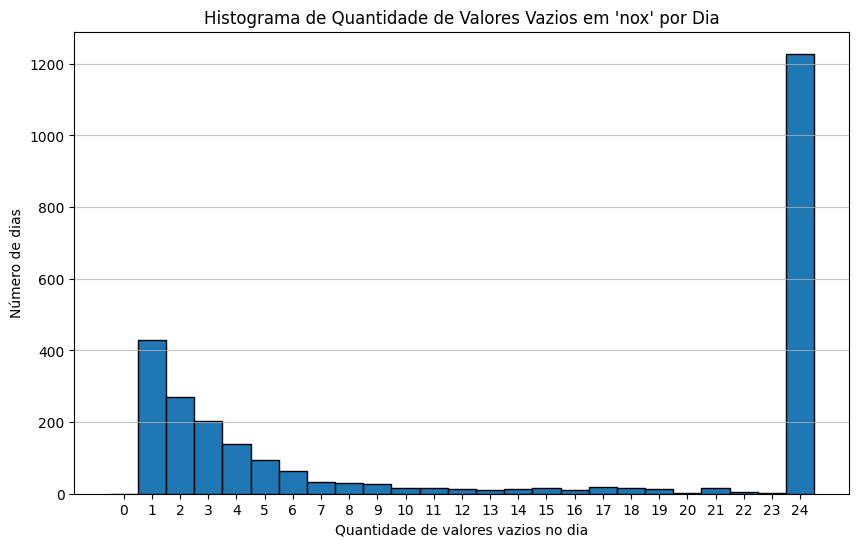

In [49]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['nox_nulos_no_dia'] != 0].groupby('data_formatada')['nox_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'nox' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [50]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['nox_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['nox'].isnull().sum()
df_sensor_tijuca.loc[mask, 'nox'] = df_sensor_tijuca[mask]['nox'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'nox'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2988 linhas foram preenchidas com interpolate na coluna 'nox'.
Foram preenchido 8% de dados


In [51]:
df_sensor_tijuca['nox'].describe()

,nox
count,81183.000000
mean,52.551004
std,33.912702
min,0.000000
25%,28.650000
50%,45.550000
75%,68.350000
max,418.470000


### Dióxido de Enxofre Tijuca

In [52]:
df_sensor_tijuca['so2'].describe()

,so2
count,76311.000000
mean,3.804887
std,5.699449
min,0.000000
25%,0.830000
50%,2.140000
75%,4.390000
max,159.820000


In [53]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 37668


In [54]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['so2_nulos_no_dia'] = (
    df_sensor_tijuca['so2'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-54-4236691935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['so2_nulos_no_dia'] = (


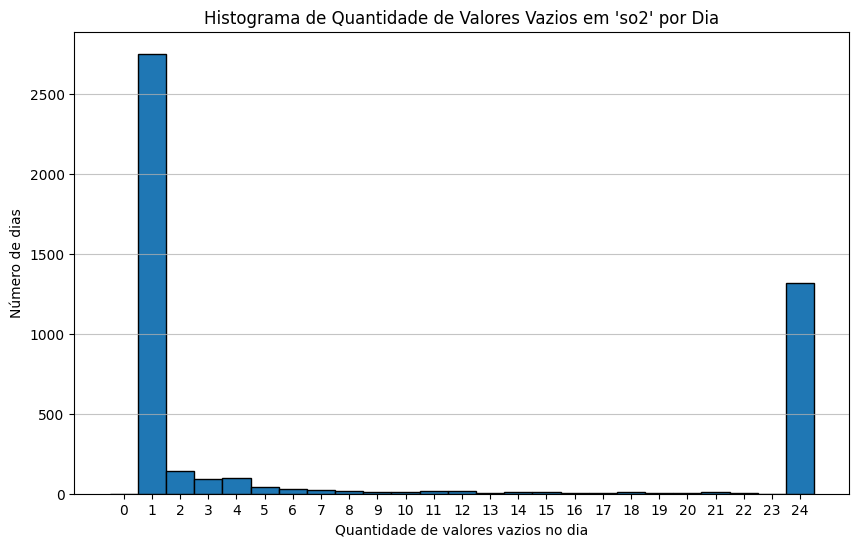

In [55]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [56]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['so2'].isnull().sum()
df_sensor_tijuca.loc[mask, 'so2'] = df_sensor_tijuca[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

4085 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 11% de dados


In [57]:
df_sensor_tijuca['so2'].describe()

,so2
count,80396.000000
mean,3.753762
std,5.626165
min,0.000000
25%,0.820000
50%,2.110000
75%,4.330000
max,159.820000


### Ozônio Tijuca

In [58]:
df_sensor_tijuca['o3'].describe()

,o3
count,103743.000000
mean,30.155529
std,24.554466
min,0.000000
25%,12.220000
50%,25.000000
75%,41.450000
max,295.490000


In [59]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 10236


In [60]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['o3_nulos_no_dia'] = (
    df_sensor_tijuca['o3'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-60-2377919458.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['o3_nulos_no_dia'] = (


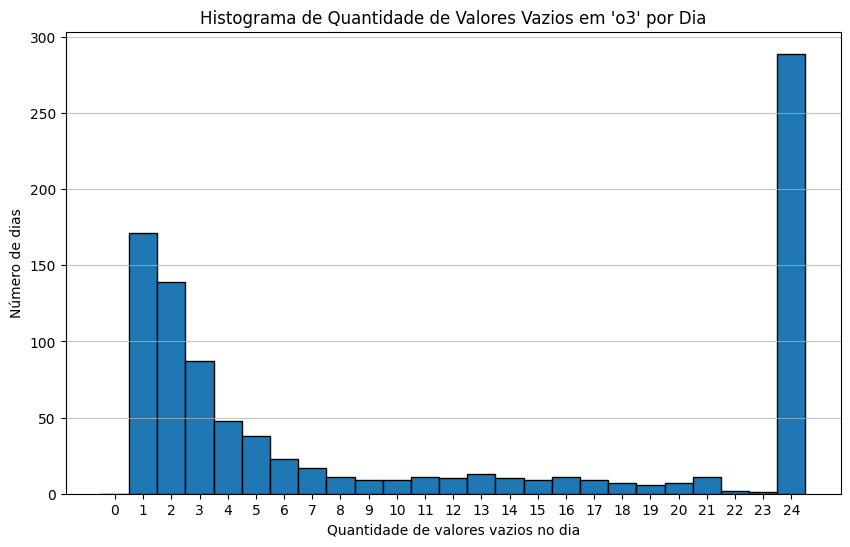

In [61]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [62]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['o3'].isnull().sum()
df_sensor_tijuca.loc[mask, 'o3'] = df_sensor_tijuca[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1230 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 12% de dados


In [63]:
df_sensor_tijuca['o3'].describe()

,o3
count,104973.000000
mean,30.160463
std,24.521235
min,0.000000
25%,12.240000
50%,25.030000
75%,41.460000
max,295.490000


### PM10 Tijuca

In [64]:
df_sensor_tijuca['pm10'].describe()

,pm10
count,107967.000000
mean,31.912483
std,18.205227
min,0.000000
25%,20.000000
50%,28.000000
75%,40.000000
max,310.000000


In [65]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_tijuca[df_sensor_tijuca['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 6012


In [66]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_tijuca['pm10_nulos_no_dia'] = (
    df_sensor_tijuca['pm10'].isnull()
    .groupby(df_sensor_tijuca['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

/tmp/ipython-input-66-4181455644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca['pm10_nulos_no_dia'] = (


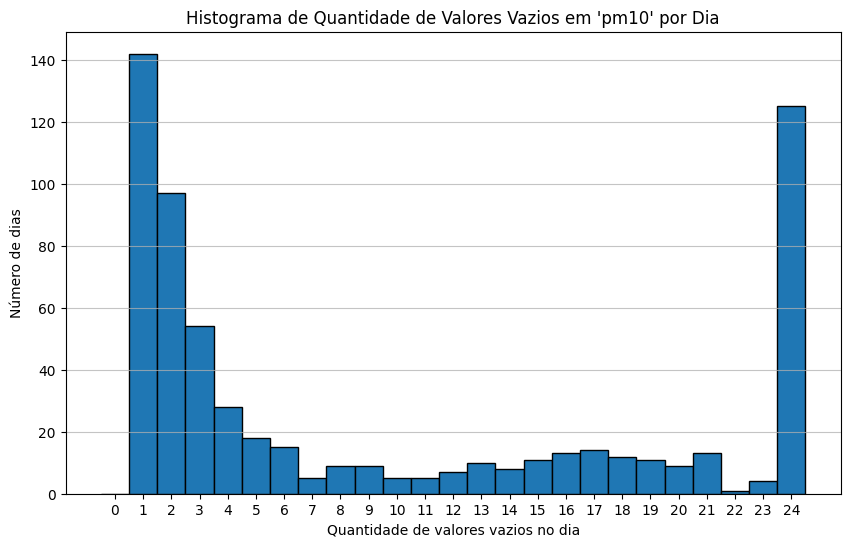

In [67]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_tijuca[df_sensor_tijuca['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [68]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_tijuca['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_tijuca[mask]['pm10'].isnull().sum()
df_sensor_tijuca.loc[mask, 'pm10'] = df_sensor_tijuca[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

790 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 13% de dados


In [69]:
df_sensor_tijuca['pm10'].describe()

,pm10
count,108757.000000
mean,31.913941
std,18.220388
min,0.000000
25%,20.000000
50%,28.000000
75%,40.000000
max,310.000000


In [70]:
droping_columns = ['nome_estacao', 'chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'no_nulos_no_dia', 'no2_nulos_no_dia', 'nox_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia']

df_sensor_tijuca.drop(columns=droping_columns, inplace=True)

/tmp/ipython-input-70-2003815199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_tijuca.drop(columns=droping_columns, inplace=True)


# Criando nova feature (AQI)

| MP₁₀ (µg/m³) 24h | MP₂.₅ (µg/m³) 24h | O₃ (µg/m³) 8h | CO (ppm) 8h | NO₂ (µg/m³) 1h | SO₂ (µg/m³) 24h | Índice | Qualidade do Ar | Efeitos |
|------------------|------------------|---------------|-------------|----------------|------------------|--------|------------------|---------|
| 0 - 50           | 0 - 25           | 0 - 100       | 0 - 9       | 0 - 200        | 0 - 20           | 0 - 40 | N1 - Boa         | - |
| >50 - 100        | >25 - 50         | >100 - 130    | >9 - 11     | >200 - 240     | >20 - 40         | 41 - 80 | N2 - Moderada     | Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar sintomas como tosse seca e cansaço. A população em geral não é afetada. |
| >100 - 150       | >50 - 75         | >130 - 160    | >11 - 13    | >240 - 320     | >40 - 365        | 81 - 120 | N3 - Ruim         | Toda a população pode apresentar sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta. Pessoas de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas) podem apresentar efeitos mais sérios na saúde. |
| >150 - 250       | >75 - 125        | >160 - 200    | >13 - 15    | >320 - 1130    | >365 - 800       | 121 - 200 | N4 - Muito Ruim   | Toda a população pode apresentar agravamento dos sintomas como tosse seca, cansaço, ardor nos olhos, nariz e garganta e ainda falta de ar e respiração ofegante. Efeitos ainda mais graves à saúde de grupos sensíveis (crianças, idosos e pessoas com doenças respiratórias e cardíacas). |
| >250 - 600       | >125 - 300       | >200 - 800    | >15 - 50    | >1130 - 3750   | >800 - 2620      | 201 - 400 | N5 - Péssima      | Toda a população pode apresentar sérios riscos de manifestações de doenças respiratórias e cardiovasculares. Aumento de mortes prematuras em pessoas de grupos sensíveis. |


In [71]:
# Carrega o DataFrame
df = df_sensor_tijuca.copy()

# Converte e ordena
df['data'] = pd.to_datetime(df['data'])
df = df.sort_values(by='data')

In [72]:
# Define faixas com interpolação linear (c_low, c_high, i_low, i_high)
faixas_aqi = {
    'pm10':   [(0, 50, 0, 40), (50, 100, 41, 80), (100, 150, 81, 120), (150, 250, 121, 200), (250, 600, 201, 400)],
    'pm2_5':  [(0, 25, 0, 40), (25, 50, 41, 80), (50, 75, 81, 120), (75, 125, 121, 200), (125, 300, 201, 400)],
    'o3':     [(0, 100, 0, 40), (100, 130, 41, 80), (130, 160, 81, 120), (160, 200, 121, 200), (200, 800, 201, 400)],
    'co':     [(0, 9, 0, 40), (9, 11, 41, 80), (11, 13, 81, 120), (13, 15, 121, 200), (15, 50, 201, 400)],
    'no2':    [(0, 200, 0, 40), (200, 240, 41, 80), (240, 320, 81, 120), (320, 1130, 121, 200), (1130, 3750, 201, 400)],
    'so2':    [(0, 20, 0, 40), (20, 40, 41, 80), (40, 365, 81, 120), (365, 800, 121, 200), (800, 2620, 201, 400)],
}

In [73]:
# Função de interpolação para cálculo contínuo do AQI
def calcular_aqi(valor, faixas):
    for c_low, c_high, i_low, i_high in faixas:
        if c_low <= valor <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (valor - c_low) + i_low
    return np.nan  # Fora das faixas

In [74]:
# Função para média 8h móvel diária (máxima por dia)
def media_8h_movel(df, col):
    resultados = []
    for dia, grupo in df.groupby('data_formatada'):
        grupo = grupo.sort_values('data')
        grupo = grupo.set_index('data')
        rol = grupo[col].rolling('8h', min_periods=6).mean()
        max_rol = rol.max()
        resultados.append((dia, max_rol))
    return pd.Series(dict(resultados))

In [75]:
# Médias 24h dos poluentes diários
df_diario = df.groupby('data_formatada')[['pm10', 'pm2_5', 'so2']].mean()

# Médias móveis 8h para O3 e CO
o3_8h_max = media_8h_movel(df, 'o3')
co_8h_max = media_8h_movel(df, 'co')

# NO2: pega maior valor por dia
no2_1h_max = df.groupby('data_formatada')['no2'].max()

# Monta df_aqi
df_aqi = df_diario.copy()
df_aqi['o3_8h_max'] = o3_8h_max
df_aqi['co_8h_max'] = co_8h_max
df_aqi['no2_1h_max'] = no2_1h_max

In [76]:
# Aplica cálculo de AQI contínuo por poluente
for poluente, faixas in faixas_aqi.items():
    col_ref = {
        'o3': 'o3_8h_max',
        'co': 'co_8h_max',
        'no2': 'no2_1h_max'
    }.get(poluente, poluente)

    df_aqi[f'{poluente}_aqi'] = df_aqi[col_ref].apply(
        lambda x: calcular_aqi(x, faixas) if pd.notnull(x) else np.nan
    )

# AQI final do dia: maior valor entre os poluentes
col_aqis = [f'{p}_aqi' for p in ['pm10', 'pm2_5', 'so2', 'o3', 'co', 'no2']]
df_aqi['aqi'] = df_aqi[col_aqis].max(axis=1)

In [77]:
# Classificação da qualidade do ar com base no AQI real
def classifica_qualidade(aqi):
    if aqi <= 40:
        return 'N1 - Boa'
    elif aqi <= 80:
        return 'N2 - Moderada'
    elif aqi <= 120:
        return 'N3 - Ruim'
    elif aqi <= 200:
        return 'N4 - Muito Ruim'
    else:
        return 'N5 - Péssima'

df_aqi['classificacao'] = df_aqi['aqi'].apply(classifica_qualidade)
df_aqi.reset_index(inplace=True)

In [78]:
# Arredonda o AQI final para inteiro
df_aqi['aqi'] = df_aqi['aqi'].round().astype('Int64')

# Mantém apenas as colunas desejadas
df_aqi = df_aqi[['data_formatada', 'aqi', 'classificacao']]

In [79]:
# Agrupamento por data_formatada
df_gruped = df_sensor_tijuca.groupby('data_formatada', as_index=False).mean()

# Merge com a tabela de qualidade do ar
df_merged = df_gruped.merge(
    df_aqi[['classificacao', 'aqi', 'data_formatada']],
    left_on='data_formatada',
    right_on='data_formatada',
    how='left'
)

In [80]:
df_merged.shape

(4750, 19)

In [81]:
df_sensor_tijuca.head()

,data,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,lat,lon,data_formatada,ano,mes
34918,2012-01-01 00:30:00,0.0,24.62,88.31,0.07,NaN,NaN,NaN,0.36,24.71,27.0,NaN,-22.924915,-43.232657,2012-01-01,2012,1
34919,2012-01-01 01:30:00,0.4,23.50,93.05,0.11,NaN,NaN,NaN,0.28,22.74,28.0,NaN,-22.924915,-43.232657,2012-01-01,2012,1
34920,2012-01-01 02:30:00,1.0,22.51,98.06,0.10,NaN,NaN,NaN,0.27,19.22,28.0,NaN,-22.924915,-43.232657,2012-01-01,2012,1
718693,2012-01-01 03:30:00,0.0,21.47,98.40,0.06,NaN,NaN,NaN,1.51,24.55,36.0,NaN,-22.924915,-43.232657,2012-01-01,2012,1
718694,2012-01-01 04:30:00,0.2,21.36,98.41,0.08,NaN,NaN,NaN,1.89,19.00,40.0,NaN,-22.924915,-43.232657,2012-01-01,2012,1


In [82]:
df_sensor_tijuca.to_csv('tijuca_per_hour.csv', index=False)

# Gerando CSV de saída com a estação de Tijuca preenchida


In [ ]:
df_merged['lat'] = -22.924915
df_merged['lon'] = 	-43.232657
df_merged['estacao'] = 'Tijuca'
df_merged['ano'] = pd.to_datetime(df_merged['data_formatada']).dt.year
df_merged['mes'] = pd.to_datetime(df_merged['data_formatada']).dt.month

df_merged.head()

# Reorder columns
new_order = ['data_formatada', 'estacao', 'ano', 'mes', 'lat', 'lon',
             'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5',
             'aqi', 'classificacao']
df_merged = df_merged[new_order]

display(df_merged.head())

,data_formatada,estacao,ano,mes,lat,lon,chuva,temp,ur,co,no,no2,nox,so2,o3,pm10,pm2_5,aqi,classificacao
0,2012-01-01,Tijuca,2012,1,-22.924915,-43.232657,0.216667,23.225833,95.107500,0.123750,NaN,NaN,NaN,3.373333,14.329583,22.375000,NaN,18,N1 - Boa
1,2012-01-02,Tijuca,2012,1,-22.924915,-43.232657,0.791667,20.066250,98.162500,0.264167,NaN,NaN,NaN,2.997917,10.927083,15.708333,NaN,13,N1 - Boa
2,2012-01-03,Tijuca,2012,1,-22.924915,-43.232657,0.000000,23.855417,77.530417,0.161667,NaN,NaN,NaN,5.775625,9.932917,26.208333,NaN,21,N1 - Boa
3,2012-01-04,Tijuca,2012,1,-22.924915,-43.232657,0.000000,25.740833,71.502500,0.171250,NaN,NaN,NaN,2.354167,19.878750,27.458333,NaN,22,N1 - Boa
4,2012-01-05,Tijuca,2012,1,-22.924915,-43.232657,0.000000,25.865000,77.910833,0.103333,NaN,NaN,NaN,1.582292,35.780833,29.166667,NaN,26,N1 - Boa


In [ ]:
df_merged.to_csv('tijuca.csv', index=False)